# Imports

In [1]:
import os
import numpy as np
import pandas as pd
# Optional: set the device to run
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from pyboostlss.model import *
from pyboostlss.distributions.MVN import *
from pyboostlss.distribution_loss_metric import *
from pyboostlss.utils import *

import plotnine
from plotnine import *
plotnine.options.figure_size = (20, 10)

# Specifiy Distribtution

In [2]:
distribution = MVN()

# Data

In [3]:
n_target = 3
n_param = distribution.n_dist_param(n_target)
data_sim = pd.read_csv("data/sim_triv_gaussian.csv")

X_train = data_sim["x"].values.reshape(-1,1)
y1 = data_sim["y1"].values.reshape(-1,1)
y2 = data_sim["y2"].values.reshape(-1,1)
y3 = data_sim["y3"].values.reshape(-1,1)
Y_train = np.concatenate([y1, y2, y3], axis=1)
n_fill = n_param - n_target
np_fill = np.ones((Y_train.shape[0], n_fill))
Y_train = np.concatenate([Y_train, np_fill],axis=1) 

# Hyper-Parameter Optimization via Optuna

In [4]:
np.random.seed(123)

# Specify eval_sets on which the model is evaluated on
eval_sets = [{'X': X_train, 'y': Y_train}]

# Specifies the parameters and their value range. The structure is as follows: "hyper-parameter": [lower_bound, upper_bound]. Currently, only the following hyper-parameters can be optimized:
hp_dict = {"lr": [1e-3, 1],  
           "max_depth": [1, 4],
           "sketch_outputs": [1,10],
           "lambda_l2": [0, 40],     
           "colsample": [0.2, 1.0],
           "subsample": [0.2, 1.0],
           "min_gain_to_split": [0, 500]
          }  

opt_param = pyboostlss.hyper_opt(dist=distribution,
                                 params=hp_dict,
                                 X_train=X_train,
                                 Y_train=Y_train,
                                 eval_sets=eval_sets,
                                 es=20,
                                 use_hess=True,
                                 sketch_method="proj",
                                 seed=123,
                                 ntrees=500,                 # Number of boosting iterations.
                                 max_minutes=120,            # Time budget in minutes, i.e., stop study after the given number of minutes.
                                 n_trials=10,                # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                                 silence=False)              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.

[I 2022-12-02 12:20:20,233] A new study created in memory with name: Py-BoostLSS Hyper-Parameter Optimization


10000


C:\Users\Alexander\.julia\v0.6\Conda\deps\usr\envs\pyboost\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

[12:20:27] Stdout logging level is INFO.
[12:20:27] GDBT train starts. Max iter 500, early stopping rounds 20
[12:20:29] Iter 0; Sample 0, NLL-score = 44646.188091928416; 
[12:21:12] Iter 499; Sample 0, NLL-score = 34949.16571029645; 
[I 2022-12-02 12:21:12,960] Trial 0 finished with value: 34948.4296875 and parameters: {'lr': 0.7588720250150925, 'max_depth': 1, 'sketch_outputs': 4, 'lambda_l2': 39.932598259399605, 'colsample': 0.413528494134918, 'subsample': 0.7596808395214207, 'min_gain_to_split': 229.45028186570886}. Best is trial 0 with value: 34948.4296875.
[12:21:12] Stdout logging level is INFO.
[12:21:12] GDBT train starts. Max iter 500, early stopping rounds 20
[12:21:13] Iter 0; Sample 0, NLL-score = 44184.42658689301; 
[12:21:54] Iter 499; Sample 0, NLL-score = 34501.88614689417; 
[I 2022-12-02 12:21:55,611] Trial 1 finished with value: 34501.88671875 and parameters: {'lr': 0.5583994318053701, 'max_depth': 3, 'sketch_outputs': 1, 'lambda_l2': 4.405370215249742, 'colsample': 

# Model Training

In [9]:
opt_params = opt_param.copy()

pyboostlss_model = pyboostlss.train(dist=distribution, 
                                    X_train=X_train,
                                    Y_train=Y_train,
                                    lr=opt_params["lr"], 
                                    lambda_l2=opt_params["lambda_l2"],
                                    max_depth=opt_params["max_depth"],
                                    sketch_outputs=opt_params["sketch_outputs"],
                                    colsample=opt_params["colsample"],
                                    subsample=opt_params["subsample"],
                                    min_gain_to_split=opt_params["min_gain_to_split"],
                                    ntrees=opt_params["opt_rounds"],
                                    use_hess=True,
                                    verbose=100,                                
                                    sketch_method="proj",
                                    seed=123)

[12:33:22] Stdout logging level is INFO.
[12:33:22] GDBT train starts. Max iter 500, early stopping rounds 100
[12:33:22] Iter 0; 
[12:33:30] Iter 100; 
[12:33:37] Iter 200; 
[12:33:45] Iter 300; 
[12:33:53] Iter 400; 
[12:34:01] Iter 499; 


# Predict

In [6]:
predt_params = distribution.predict(pyboostlss_model,
                                    X_train,
                                    n_target,
                                    pred_type="parameters")

predt_params

,location_1,location_2,location_3,scale_1,scale_2,scale_3,rho_21,rho_31,rho_32
0,1.051094,-0.069180,1.169613,0.589899,1.904451,1.085180,0.751515,0.243364,0.735803
1,1.051094,-0.069180,1.169613,0.589899,1.904451,1.085180,0.751515,0.243364,0.735803
2,1.051094,-0.069180,1.169613,0.589899,1.904451,1.085180,0.751515,0.243364,0.735803
3,1.051094,-0.069180,1.169613,0.589899,1.904451,1.085180,0.751515,0.243364,0.735803
4,1.051094,-0.069180,1.169613,0.589899,1.904451,1.085180,0.751515,0.243364,0.735803
...,...,...,...,...,...,...,...,...,...
9995,-0.040271,0.029732,1.058736,0.580726,0.933866,0.974666,0.922608,0.506872,0.709629
9996,-0.040271,0.029732,1.058736,0.580726,0.933866,0.974666,0.922608,0.506872,0.709629
9997,-0.040271,0.029732,1.058736,0.580726,0.933866,0.974666,0.922608,0.506872,0.709629
9998,-0.040271,0.029732,1.058736,0.580726,0.933866,0.974666,0.922608,0.506872,0.709629


In [7]:
torch.manual_seed(123)
predt_samples = distribution.predict(pyboostlss_model,
                                     X_train,
                                     n_target,
                                     pred_type="samples",   
                                     n_samples=100)
predt_samples.shape

torch.Size([100, 10000, 3])

# Plot

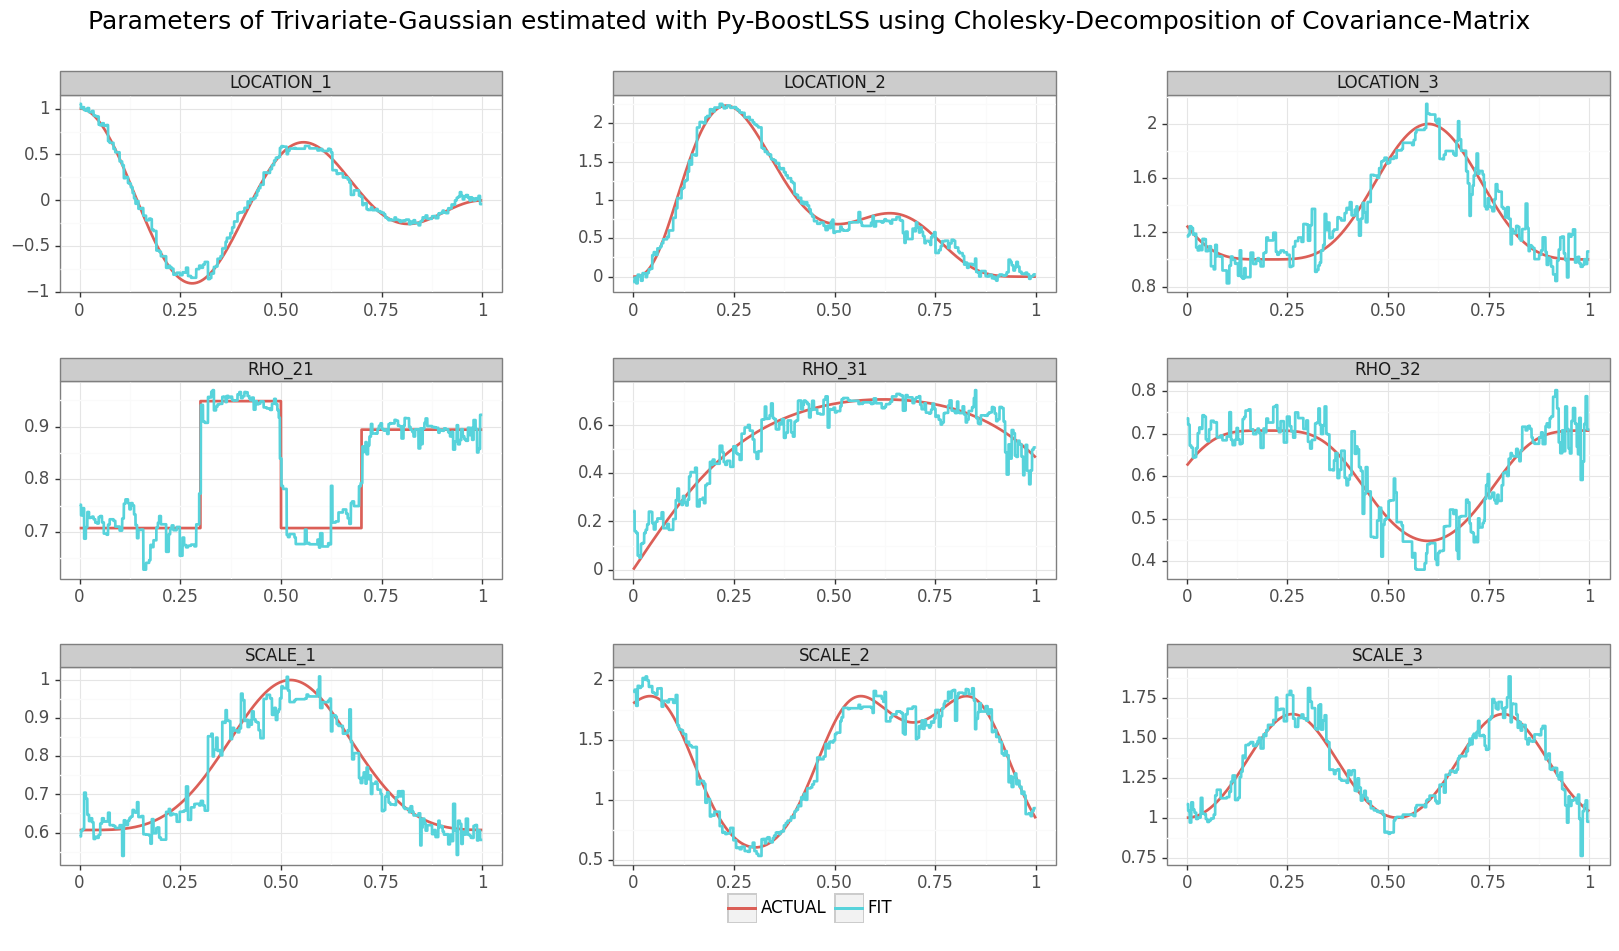

In [8]:
predt_params["x"] = X_train
dist_params = list(predt_params.columns)

drop_cols = [resp for resp in list(data_sim.columns) if "y" in resp]

plot_df_actual = pd.melt(data_sim.drop(columns=drop_cols, axis=0),
                         id_vars="x",
                         value_vars=dist_params)

plot_df_actual["type"] = "ACTUAL"

plot_df_fitted = pd.melt(predt_params,
                         id_vars="x",
                         value_vars=dist_params)

plot_df_fitted["type"] = "FIT"

plot_df = pd.concat([plot_df_actual, plot_df_fitted])   

plot_df["variable"] = plot_df.variable.str.upper()


plot_params = (ggplot(plot_df,
                      aes(x="x",
                          y="value",
                          color="type")) +
               geom_line(size=1.1) + 
               facet_wrap("variable",
                          # ncol=2,
                          scales="free") + 
               labs(title="Parameters of Trivariate-Gaussian estimated with Py-BoostLSS using Cholesky-Decomposition of Covariance-Matrix\n",
                    x="",
                    y="") + 
               theme_bw(base_size=15) + 
               theme(legend_position="bottom",
                     legend_title = element_blank(),
                     subplots_adjust={"wspace": 0.25,
                                      "hspace": 0.45})
              )


print(plot_params)